In [1]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


### Q1. How can we develop a metric for understanding energy performance and peer building comparison that accounts for the differences in building and occupancy characteristics that impact consumption?

In [3]:
import os.path
!mkdir -p data
fname = r'data/nyc_benchmarking_disclosure_data_reported_in_2016.csv'
if not os.path.isfile(fname):
    # Read data
    df_xls = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

    # Convert to .csv
    df_xls.to_csv(r'data/nyc_benchmarking_disclosure_data_reported_in_2016.csv', encoding='utf-8')
    del df_xls
    
df = pd.read_csv(fname, dtype={"Record Number": object,
                               "Reported NYC Building Identification Numbers (BINs)": object})
len(df)

13223

In [4]:
!wget -nc -O data/mappluto_bx.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/bx_mappluto_16v2.zip
!wget -nc -O data/mappluto_mn.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
!wget -nc -O data/mappluto_bk.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/bk_mappluto_16v2.zip
!wget -nc -O data/mappluto_qn.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/qn_mappluto_16v2.zip
!wget -nc -O data/mappluto_si.zip https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/si_mappluto_16v2.zip

!cd data; unzip -f mappluto_bx.zip
!cd data; unzip -f mappluto_bk.zip
!cd data; unzip -f mappluto_qn.zip
!cd data; unzip -f mappluto_si.zip
!cd data; unzip -f mappluto_mn.zip
from collections import OrderedDict
pluto = gpd.GeoDataFrame(pd.concat(gpd.read_file(f) for f in glob.glob("data/*MapPLUTO.shp")))
#pluto['BBL'] = pluto['BBL'].apply(lambda x: x[:-1])
# pluto = pluto.dropna(subset=["CT2010", "CB2010"])
pluto.crs = {"init": "epsg:2263"}
pluto = pluto.to_crs({"init": "epsg:4269"})
pluto.head()

File `data/mappluto_bx.zip' already there; not retrieving.
File `data/mappluto_mn.zip' already there; not retrieving.
File `data/mappluto_bk.zip' already there; not retrieving.
File `data/mappluto_qn.zip' already there; not retrieving.
File `data/mappluto_si.zip' already there; not retrieving.
Archive:  mappluto_bx.zip
Archive:  mappluto_bk.zip
Archive:  mappluto_qn.zip
Archive:  mappluto_si.zip
Archive:  mappluto_mn.zip
OrderedDict([(u'Borough', 'str:2'), (u'Block', 'int:9'), (u'Lot', 'int:4'), (u'CD', 'int:4'), (u'CT2010', 'str:7'), (u'CB2010', 'str:5'), (u'SchoolDist', 'str:2'), (u'Council', 'int:4'), (u'ZipCode', 'int:9'), (u'FireComp', 'str:4'), (u'PolicePrct', 'int:4'), (u'HealthArea', 'int:4'), (u'SanitBoro', 'str:1'), (u'SanitDistr', 'str:2'), (u'SanitSub', 'str:2'), (u'Address', 'str:28'), (u'ZoneDist1', 'str:9'), (u'ZoneDist2', 'str:9'), (u'ZoneDist3', 'str:9'), (u'ZoneDist4', 'str:9'), (u'Overlay1', 'str:4'), (u'Overlay2', 'str:4'), (u'SPDist1', 'str:6'), (u'SPDist2', 'str:6

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,BX,2318,22,201,51,1024,07,8,10454,E060,40,3800,2,01,1A,270 EAST 137 STREET,M1-4/R7A,,,,,,MX-13,,,,N,K7,05,0,P,SOBRO DEVELOPMENT COR,5139,11700,11700,0,11700,0,0,0,0,0,2,1,3.0,0,3,39.67,100.0,39.00,100.0,,0,Y,3,5,138600.0,831150.0,0.0,432000.0,1911,2000,0,,,2.28,4.0,2.0,4.0,2,2.023180e+09,0,0051,1004162,234443,6a,,209S002,20902,E-227,0.0,,1,16V2,0,330.014939,5994.020237,POLYGON ((-73.92806702357278 40.80998925621392...
1,BX,2296,42,201,19,1009,07,8,10454,E060,40,4700,2,01,1A,69 BRUCKNER BOULEVARD,M1-2/R6A,,,,,,MX-1,,,,N,S3,04,0,P,"MPM 67, LLC",2000,5120,1280,3840,0,1280,0,0,0,0,2,1,4.0,3,4,20.00,100.0,20.00,64.0,,0,N,5,5,24211.0,35042.0,0.0,0.0,1915,0,0,,,2.56,3.0,2.0,3.0,2,2.022960e+09,0,0019,1004696,233144,6a,,209S010,20902,,0.0,,1,16V2,0,243.507148,2035.046764,"POLYGON ((-73.92619928804311 40.8064436013445,..."
2,BX,2296,11,201,19,1009,07,8,10454,E060,40,4700,2,01,1A,348 EAST 134 STREET,M1-2/R6A,,,,,,MX-1,,,,N,E9,06,0,P,MACK REALTY DEVELOPME,2500,4875,4875,0,0,0,0,4875,0,0,2,1,1.0,0,1,25.00,100.0,25.00,85.0,,3,N,5,2,18000.0,188100.0,0.0,170100.0,2008,0,0,,,1.95,3.0,2.0,3.0,2,2.022960e+09,0,0019,1004633,233295,6a,,209S010,20902,,0.0,,1,16V2,0,250.985214,2432.957975,POLYGON ((-73.92624372459986 40.80710035847443...
3,BX,2296,51,201,19,1009,07,8,10454,E060,40,4700,2,01,1A,51 BRUCKNER BOULEVARD,M1-2/R6A,,,,,,MX-1,,,,N,S4,04,0,P,51 BRUCKNER LLC,2000,5120,700,4420,0,700,0,0,0,0,2,1,4.0,4,5,20.00,100.0,20.00,64.0,,0,N,5,5,10203.0,13989.0,0.0,0.0,1915,2003,0,,,2.56,3.0,2.0,3.0,2,2.022960e+09,0,0019,1004537,233231,6a,,209S010,20902,,0.0,,1,16V2,0,245.902974,2111.489026,POLYGON ((-73.92659470483834 40.80692966902306...
4,BX,2319,37,201,51,1026,07,8,10451,E060,40,3800,2,01,1A,2441 3 AVENUE,M1-3/R8,,,,,,MX-1,,,,N,D9,03,0,P,225 EAST REALTY PARTN,35049,83936,46640,37296,1000,0,4000,17364,24276,0,2,2,5.0,46,50,192.58,205.0,71.25,135.0,,0,Y,3,5,315450.0,1294650.0,0.0,67403.0,1917,2008,0,,,2.39,7.2,5.0,6.5,2,2.023190e+09,0,0051,1003568,234178,6a,,209S001,20902,,0.0,,1,16V2,0,791.368728,35247.169036,POLYGON ((-73.93065658344736 40.80937264327267...


In [5]:
ll80_pluto = gpd.GeoDataFrame(df.merge(pluto, left_on="NYC Borough, Block and Lot (BBL)", right_on="BBL"))
len(ll80_pluto)

/opt/conda/lib/python2.7/site-packages/pandas/core/indexes/base.py:2699: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/conda/lib/python2.7/site-packages/pandas/core/indexes/base.py:1696: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


2223

## Census data loading starts here

In [6]:
import geopandas as gpd
acs_2015_nys = gpd.read_file("data/ACS_2015_5YR_BG_36_NEW_YORK.gdb/")

OrderedDict([(u'STATEFP', 'str:2'), (u'COUNTYFP', 'str:3'), (u'TRACTCE', 'str:6'), (u'BLKGRPCE', 'str:1'), (u'GEOID', 'str:12'), (u'NAMELSAD', 'str:13'), (u'MTFCC', 'str:5'), (u'FUNCSTAT', 'str:1'), (u'ALAND', 'float'), (u'AWATER', 'float'), (u'INTPTLAT', 'str:11'), (u'INTPTLON', 'str:12'), (u'Shape_Length', 'float'), (u'Shape_Area', 'float'), (u'GEOID_Data', 'str:255')])


In [7]:
NYS_COUNTIES = set(['005', '047', '061', '081', '085'])
"""
005 - Bronx (Bronx)
047 - Kings (Brooklyn)
061 - New York (Manhattan)
081 - Queens
085 - Richmond (Staten Island)
"""
nyc = acs_2015_nys[acs_2015_nys["COUNTYFP"].isin(NYS_COUNTIES)]
nyc.crs

{'init': u'epsg:4269'}

In [8]:
dog = None
columns_of_interest = set([
        "B19013e1", # median household income
        "B25001e1", # total housing units
        "B25002e2", # OCCUPANCY STATUS: Occupied: Housing units -- (Estimate)
        "B25002e3", # OCCUPANCY STATUS: Vacant: Housing units -- (Estimate)
        "B25010e1",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Total: Occupied housing units -- (Estimate)
        "B25010m1",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Total: Occupied housing units -- (Margin of Error)
        "B25010e2",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Owner occupied: Occupied housing units -- (Estimate)
        "B25010m2",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Owner occupied: Occupied housing units -- (Margin of Error)
        "B25010e3",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Renter occupied: Occupied housing units -- (Estimate)
        "B25010m3",# AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE: Renter occupied: Occupied housing units -- (Margin of Error)
        "B25018e1" # MEDIAN NUMBER OF ROOMS: Total: Housing units -- (Estimate)
    ])
block_level_info = pd.DataFrame()
relevant_fnames = []
for f in {'data/ACS_2015_5YR_BG_36_NEW_YORK.gdb/a00000018.gdbtable',
 'data/ACS_2015_5YR_BG_36_NEW_YORK.gdb/a0000001e.gdbtable'}:
    if columns_of_interest == set():
        break
    gdf = gpd.read_file(f)
    used_columns = []
    for column in columns_of_interest:
        if column in gdf.columns:
            relevant_fnames.append(f)
            used_columns.append(column)
            block_level_info[column] = gdf[column]
            if 'GEOID' not in block_level_info.columns:
                block_level_info['GEOID'] = gdf['GEOID']
    [columns_of_interest.remove(c) for c in used_columns]

    del gdf


OrderedDict([(u'GEOID', 'str:255'), (u'B19001e1', 'int'), (u'B19001m1', 'int'), (u'B19001e2', 'int'), (u'B19001m2', 'int'), (u'B19001e3', 'int'), (u'B19001m3', 'int'), (u'B19001e4', 'int'), (u'B19001m4', 'int'), (u'B19001e5', 'int'), (u'B19001m5', 'int'), (u'B19001e6', 'int'), (u'B19001m6', 'int'), (u'B19001e7', 'int'), (u'B19001m7', 'int'), (u'B19001e8', 'int'), (u'B19001m8', 'int'), (u'B19001e9', 'int'), (u'B19001m9', 'int'), (u'B19001e10', 'int'), (u'B19001m10', 'int'), (u'B19001e11', 'int'), (u'B19001m11', 'int'), (u'B19001e12', 'int'), (u'B19001m12', 'int'), (u'B19001e13', 'int'), (u'B19001m13', 'int'), (u'B19001e14', 'int'), (u'B19001m14', 'int'), (u'B19001e15', 'int'), (u'B19001m15', 'int'), (u'B19001e16', 'int'), (u'B19001m16', 'int'), (u'B19001e17', 'int'), (u'B19001m17', 'int'), (u'B19013e1', 'int'), (u'B19013m1', 'int'), (u'B19025e1', 'int'), (u'B19025m1', 'int'), (u'B19025Ae1', 'int'), (u'B19025Am1', 'int'), (u'B19025Be1', 'int'), (u'B19025Bm1', 'int'), (u'B19025Ce1', 'int'

In [9]:
block_level_info["GEOID_clean"] = block_level_info["GEOID"].apply(lambda x: x.split("US")[1])
block_census_merged = nyc.merge(block_level_info, left_on="GEOID", right_on="GEOID_clean")


In [10]:
final_merged = gpd.sjoin(block_census_merged, ll80_pluto, op='intersects')

/opt/conda/lib/python2.7/site-packages/pandas/core/indexes/base.py:1318: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


In [11]:
try:
    final_merged = final_merged.rename(columns={"Site EUI (kBtu/ft\xc2\xb2)": "EUI"})
except:
    pass
final_merged = final_merged.dropna(subset=["EUI"])
final_merged = final_merged[final_merged["EUI"] > 0]
final_merged["log_EUI"] = np.log(final_merged["EUI"])

In [45]:
f = final_merged
f = f.dropna(subset=["B25002e2", # occupied 
                     "B25002e3"]) # vacant
f["occupied_ratio"] = f["B25002e2"] / (f["B25002e3"] + 1.)
f["household_size"] = f["B25010e1"]
f["num_housing_units"] = f["B25001e1"]
f["median_num_rooms"] = f["B25018e1"]
f["median_income"] = f["B19013e1"]
f["floor_area"] = f['DOF Property Floor Area (ft\xc2\xb2)']
f["year_built"] = f["Year Built"]
f = f[f["DOF Property Floor Area (ft\xc2\xb2)"] > 0]
f["log_floor_area"] = np.log(f["floor_area"])
f["List of All Property Use Types at Property"].unique()
multifamily = f[f["List of All Property Use Types at Property"] == 'Multifamily Housing']
len(multifamily)

1437

In [34]:
import statsmodels.formula.api as smf
dem_model = smf.ols("log_EUI ~ occupied_ratio + household_size + num_housing_units + median_income + median_num_rooms", 
        data=f).fit()

In [53]:
interesting_columns = ["year_built",
                       "Occupancy",
                       "log_floor_area"]
dem_columns = ["occupied_ratio", 
               "household_size",
               "num_housing_units",
               "median_income",
               "median_num_rooms"]
base_model = smf.ols("log_EUI ~ {}".format(" + ".join(interesting_columns + dem_columns)), data=f).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_EUI   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     3.537
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           7.72e-31
Time:                        07:25:42   Log-Likelihood:                -2041.2
No. Observations:                1941   AIC:                             4324.
Df Residuals:                    1820   BIC:                             4998.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7072      0.719      0.983      0.326      -0.704       2.118
year_built[T.1850]    -0.8158      0.881     -0.926      0.354      -2.543       0.911
year_built[T.1887]    -0.4997      0.881     -0.567      0.571      -2.227       1.228
year_built[T.1899]    -0.1185      0.882     -0.134      0.893      -1.848       1.611
year_built[T.1900]    -0.0171      0.719     -0.024      0.981      -1.428       1.394
year_built[T.1901]    -0.2867      0.878     -0.327      0.744      -2.009       1.435
year_built[T.1902]    -0.1010      0.881     -0.115      0.909      -1.829       1.627
year_built[T.1904]    -0.3044      0.880     -0.346      0.730      -2.031       1.422
year_built[T.1905]    -1.1371      0.721     -1.578      0.115      -2.550       0.276
year_built[T.1907]    -0.2949      0.722     -0.408      0.683      -1.711       1.121
year_built[T.1908]    -0.5818      0.658     -0.884      0.377      -1.872       0.709
year_built[T.1909]    -0.2546      0.881     -0.289      0.773      -1.983       1.474
year_built[T.1910]    -1.3656      0.552     -2.475      0.013      -2.448      -0.283
year_built[T.1911]     0.0450      0.721      0.062      0.950      -1.369       1.459
year_built[T.1912]    -0.2056      0.660     -0.312      0.755      -1.500       1.088
year_built[T.1913]    -1.3339      0.622     -2.144      0.032      -2.554      -0.114
year_built[T.1914]    -1.9068      0.721     -2.646      0.008      -3.320      -0.494
year_built[T.1915]    -0.2814      0.603     -0.466      0.641      -1.465       0.902
year_built[T.1916]    -1.0561      0.655     -1.614      0.107      -2.340       0.228
year_built[T.1917]    -1.7411      0.878     -1.982      0.048      -3.464      -0.018
year_built[T.1919]    -0.5398      0.719     -0.751      0.453      -1.950       0.870
year_built[T.1920]    -1.0916      0.526     -2.074      0.038      -2.124      -0.059
year_built[T.1921]    -0.5895      0.579     -1.018      0.309      -1.725       0.546
year_built[T.1922]    -0.5332      0.528     -1.009      0.313      -1.569       0.503
year_built[T.1923]    -0.6661      0.524     -1.271      0.204      -1.694       0.362
year_built[T.1924]    -0.5858      0.522     -1.121      0.262      -1.610       0.439
year_built[T.1925]    -0.3953      0.519     -0.762      0.446      -1.412       0.622
year_built[T.1926]    -0.3575      0.518     -0.690      0.491      -1.374       0.659
year_built[T.1927]    -0.4822      0.515     -0.936      0.350      -1.493       0.528
year_built[T.1928]    -0.4456      0.515     -0.865      0.387      -1.456       0.565
year_built[T.1929]    -0.5523      0.517     -1.069      0.285      -1.566       0.461
year_built[T.1930]    -0.4127      0.519     -0.795      0.426      -1.430       0.605
year_built[T.1931]    -0.5164      0.5

### Introduction

Much work has been done to improve NYC's building energy efficiency. The first step in the process of improving efficiency is understanding and developing a baseline of efficiency. We do so in this paper, by combining three datasets:

- NYC LL84 Data (NYC, 2017)
- PLUTO Data (NYC, 2017)
- Demographic Data from the Census (Branch, 2017)


### Literature Review

A baseline involving PLUTO data and LL84 data has been developed (Kontokosta, 2014) We now add in Census data - in particular, home information at the block level - to look at multifamily housing energy usage.

### Data and methods
We load census data from one source:
1) TIGER page
This is because the TIGER page contains block-level home information combined with geospatial data. We use this data in the multifamily housing plot.

See Fig. 1 below for a view of Manhattan's census blocks.

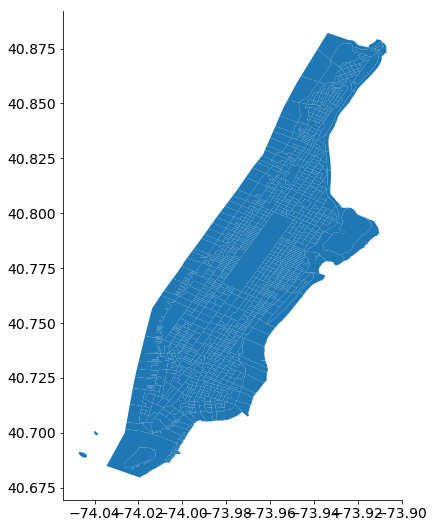

In [73]:
nyc[nyc["COUNTYFP"] == "061"].plot(figsize=(16, 9))

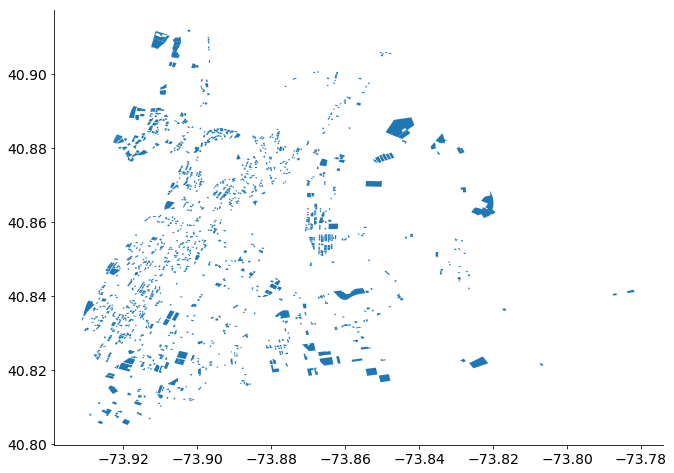

In [61]:
ll80_pluto[ll80_pluto["List of All Property Use Types at Property"] == "Multifamily Housing"].plot()

Upon joining, we end up with 1437 results.

We develop 1 model based on different building classes. It is of the following form:

```
'log_EUI ~ year_built + Occupancy + log_floor_area + occupied_ratio + household_size + num_housing_units + median_income + median_num_rooms'
```

### Results
With an R^2 of .189, we have not improved explanatory power over the .33 from (Kontakosta, 2014). However, this paper looks at Multifamily Housing while the reference paper looked at office buildings. 

In particular, significant factors were the expected ones (floor area, occupancy). The following block-level census factors factors were significant, the rest weren't.

- Household size (p .004)

A complete table follows.

Text(0,0.5,u'Log EUI')

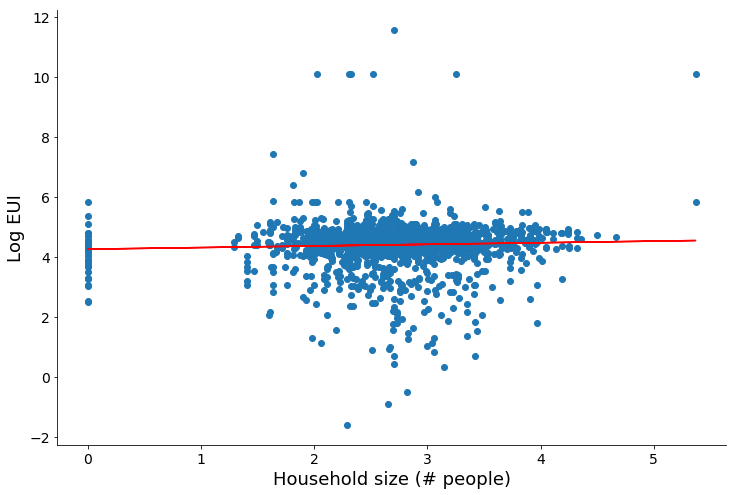

In [63]:
plt.scatter(f["household_size"], f["log_EUI"])
m = smf.ols("log_EUI ~ household_size", data=f).fit()
plt.plot(f["household_size"], m.predict(f["household_size"]), 'r-')
plt.xlabel("Household size (# people)")
plt.ylabel("Log EUI")

### Discussion and Conclusion
Given that the average household size in the nearby census block is in fact significant, it may be worth attempting to get these average household size numbers at the building level for residential units. At the census block level, we may be capturing demographic patterns or are simply lucky that there is likely spatial autocorrelation in this variable that means perhaps the census block level is disaggregated enough.

#### Limitations
We got caught up in the minutae of loading the census data and didn't spend enough time actually playing with different models to tell a story.

#### Future work
Better understanding of census data should help lead to interesting potential variables to look at. Notably, we probably need to look at the block level for any interesting results, though the tract level is perhaps worth exploration as well.

### Works Cited
City Of, N. (2017, February 7). [LL84] Data Disclosure & Reports. Retrieved November 14, 2017, from http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml

NYC, D. (n.d.). Pluto and MapPluto. Retrieved November 14, 2017, from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

Branch, G. P. (2012, September 01). TIGER/Line® with Data. Retrieved November 14, 2017, from https://www.census.gov/geo/maps-data/data/tiger-data.html

Kontokosta, C. E. (2014). A Market-Specific Methodology for a Commercial Building Energy Performance Index. The Journal of Real Estate Finance and Economics, 51(2), 288-316. doi:10.1007/s11146-014-9481-0

In [ ]:
import fiona
f = fiona.open("data/BXMapPLUTO.shp", schema=schema)

In [ ]:
schema = f.meta['schema']
schema['properties'][u"BBL"] = 'str:40'

In [ ]:
type(f.next()['properties']['BBL'])

In [ ]:
gpd.read_file("data/BXMapPLUTO.shp")

In [ ]:
!wget -nc -O data/worker_occupation.xlsx http://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/acs/a202106_ct_06_10.xlsx
!wget -nc -O data/worker_industry.xlsx http://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/acs/a202104_ct_06_10.xlsx
    
industry_tract = pd.read_excel("data/worker_industry.xlsx", skiprows=6)
#industry_tract.iloc[1]
est_or_margin = industry_tract.iloc[2]
industry_type = industry_tract.iloc[0]
new_names = []
for i in range(6, 34, 2):
    new_name = industry_tract["Unnamed: {}".format(i)].iloc[0]
    industry_tract[new_name] = industry_tract["Unnamed: {}".format(i)]
mapping = {"Unnamed: 0": "Borough",
           "Unnamed: 1": "County",
           "Unnamed: 2": "Borough Code",
           "Unnamed: 3": "Census Tract",}
industry_tract.rename(columns=mapping, inplace=True)
industry_counts = industry_tract[[c for c in industry_tract.columns if "Unnamed" not in c]][4:]

In [ ]:
occupations = pd.read_excel("data/worker_occupation.xlsx", skiprows=5)
mapping = {"Unnamed: 1": "FIPS County Code", 
           "Unnamed: 2": "DCP Borough Code",
           "Unnamed: 3": "2010 Census Tract",
           "WORKPLACE": "Borough",}
occupations.rename(columns=mapping, inplace=True)
occupations = occupations[[c for c in occupations.columns if 'Unnamed' not in c]][2:]